# Presentation Prep

- The data compiled in previous notebooks will now need to be consolidated to be presentable.
- The following dataframes will be created:
    - Building Data
        - Each building will need to be located on a map, so the address or latitude/longitude will need to be determined for each.
    - Performance Data
        - The MAPE for each model/building will need to be compiled into a single dataframe.
    - The predicted and actual electricity consumption will be graphed for a visual comparison. This data will need to be tabulated.
        - This will be accomplishing with two dataframes
            1. One single list with building data succeeding each other
            2. Separate columns for each building and their actual and predicted meter readings

In [6]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math

pd.set_option('display.max_columns', None)

In [7]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

In [8]:
with open('Data_Files/berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

In [9]:
with open('Data_Files/berkeley_building_info.pkl','rb') as read_file:
    building_data = pickle.load(read_file)

# Clean Up Building Data

In [10]:
building_list = sorted(list(set(berkeley_df['building_id'].values)))

In [11]:
building_data

,berkeley_id,square_feet,year,name,spaceUse,address,timezone,resources,ashrae_id,mae
0,173,252597,1984,Recreational Sports Facility,Other,"37.868448, -122.262184",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
1,174,43599,1998,Silver Space Sciences Laboratory Addition,Laboratory,"37.880843, -122.243914",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
2,175,54000,2015,Maxwell Family Field,CollegeUniversity,"Berkeley, California",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
3,176,110565,1994,Soda Hall,Laboratory,"37.875511, -122.258656",America/Los_Angeles,"[Steam, Electricity, Outside]",641.0,4.042443
4,177,111198,1941,Sproul Hall,Administrative,"37.869734, -122.258924",America/Los_Angeles,"[Electricity, Outside]",643.0,1.579731
...,...,...,...,...,...,...,...,...,...,...
117,291,91594,-1,Northwest Parking Garage,VehicleStorage,"37.873696, -122.265848",America/Los_Angeles,"[Electricity, Outside]",633.0,0.001653
118,292,10535,1960,Oxford Tract,Laboratory,"37.875274, -122.267085",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
119,3727,80000,2018,Chou Hall,Unspecified,"Berkeley, California",America/Los_Angeles,"[NaturalGas, Electricity, Outside]",NaN,NaN
120,5824,230000,2019,Berkeley Way West,CollegeUniversity,"Berkeley, California",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN


## Delete buildings that were not analyzed, and remove unwanted columns

In [12]:
# Only buildings with known ASHRAE ID's were analyzed for this project. All other buildings will be removed from this dataframe.

building_data_rel = building_data.dropna()

In [13]:
building_data_rel.sort_values(by='ashrae_id', inplace=True)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
# Delete irrelevant columns.

del building_data_rel['timezone']
del building_data_rel['berkeley_id']
del building_data_rel['mae']

In [15]:
# Reorder columns

building_data_rel = building_data_rel[['ashrae_id', 'name', 'address', 'spaceUse', 'year', 'square_feet', 'resources']]


In [16]:
# Delete buildings that have ASHRAE ID's but were not analyzed

building_data_list = np.array(building_data_rel['ashrae_id'].values)
np.setdiff1d(building_data_list, building_list,assume_unique=False)

building_data_rel = building_data_rel.set_index('ashrae_id', drop=True)
building_data_rel = building_data_rel.drop([566,579,591,596,613,639,650])

## Identify buildings that aren't missing latitude/longitude, Input missing addresses

In [17]:
latitude = []
longitude = []

for address in building_data_rel['address'].values:
    if address[:3] == '37.':
        address = address.split(',')
        latitude.append(address[0])
        longitude.append(address[1])
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)        

In [18]:
len(latitude)

74

In [19]:
building_data_rel.insert(2, column = 'latitude', value = latitude)
building_data_rel.insert(3, column = 'longitude', value = longitude)

In [20]:
# Manually input missing addresses

building_data_rel.loc[[567],['address']] = '2155 Center St, Berkeley, CA 94720'
building_data_rel.loc[[607],['address']] = '2545 Bancroft Way, Berkeley, CA 94704'
building_data_rel.loc[[621],['address']] = '2175 Gayley Rd, Berkeley, CA 94720'

building_data_rel.loc[[574],['address']] = 'Sather Rd, Berkeley, CA 94709'
building_data_rel.loc[[570],['address']] = 'Berkeley, CA 94720'
building_data_rel.loc[[571],['address']] = 'Berkeley, CA 94709'

In [21]:
building_data_rel

,name,address,latitude,longitude,spaceUse,year,square_feet,resources
ashrae_id,,,,,,,,
565.0,Alumni House,"37.869675, -122.261103",37.869675,-122.261103,CollegeUniversity,1954,15590,"[Electricity, Outside]"
567.0,BAMPFA,"2155 Center St, Berkeley, CA 94720",NaN,NaN,CollegeUniversity,2016,83000,"[Electricity, Outside]"
568.0,2200 Bancroft Way,2200 Bancroft Way,NaN,NaN,Unspecified,-1,14468,"[Electricity, Outside]"
569.0,Barker Hall,"37°52'26.1""N 122°15'55.7""W",NaN,NaN,Laboratory,1964,88161,"[Electricity, Outside]"
570.0,Barrows Hall,"Berkeley, CA 94720",NaN,NaN,Administrative,1964,198294,"[Electricity, Outside]"
...,...,...,...,...,...,...,...,...
649.0,Tan Hall,"37.873139, -122.256468",37.873139,-122.256468,Laboratory,1996,118376,"[Electricity, Outside]"
652.0,University Hall,"37.872023, -122.266386",37.872023,-122.266386,Administrative,1959,152987,"[Condensate, Water, Electricity, Outside]"
653.0,Valley Life Sciences Building,"37.871634, -122.262168",37.871634,-122.262168,Laboratory,1930,421939,"[Electricity, Outside]"


In [22]:
# building_data_rel.to_csv(r'Building_Data_Scratch.csv')

## Updated version of building data (includes missing latitude, longitude values)

In [23]:
# Read in updated version

building_data_updated = pd.read_csv('Building_Data.csv')

In [24]:
building_data_updated

,ashrae_id,name,address,latitude,longitude,spaceUse,year,square_feet,resources
0,632,O'Brien Hall,"37.874355, -122.259059",37.874355,-122.259059,Administrative,1959,41822,"['Electricity', 'Outside']"
1,568,2200 Bancroft Way,2200 Bancroft Way,37.867793,-122.265697,Administrative,-1,14468,"['Electricity', 'Outside']"
2,635,2224 Piedmont Ave,"2224 Piedmont Ave, Berkeley California",37.871030,-122.252820,Administrative,-1,7271,"['Electricity', 'Outside']"
3,636,2232 Piedmont Ave,"2232 Piedmont Ave, Berkeley",37.870780,-122.253040,Administrative,-1,6706,"['Electricity', 'Outside']"
4,637,2234 Piedmont Ave,"2234 Piedmont Ave, Berkeley",37.870940,-122.252810,Administrative,-1,4281,"['Electricity', 'Outside']"
...,...,...,...,...,...,...,...,...,...
69,604,2537 Haste Street,2537 Haste Street,37.866150,-122.257930,Student Services,-1,6500,"['Electricity', 'Outside']"
70,565,Alumni House,"37.869675, -122.261103",37.869675,-122.261103,Student Services,1954,15590,"['Electricity', 'Outside']"
71,580,Cesar Chavez Student Center,"37.869754, -122.259815",37.869754,-122.259815,Student Services,1960,110959,"['Electricity', 'Outside']"
72,621,Maxwell Garage,"2175 Gayley Rd, Berkeley, CA 94720",37.872400,-122.252900,Vehicle Storage,2015,104000,"['Electricity', 'Outside']"


In [25]:
building_data_updated['spaceUse'].value_counts()

Laboratory          28
Administrative      22
Library              6
Education            5
Recreation           4
Student Services     3
Gymnasium            2
Vehicle Storage      2
Dormitory            1
Museum               1
Name: spaceUse, dtype: int64

# MAPE Data

- Even though exogenous variables improved model performance as a whole, some models did not benefit from them.
- The two MAPE's for each building will be compared, and the best one will be chosen.

## Group Original Dataframe by Date, Split by Building

- The SARIMA model does not perform well with volatile (hourly) data, so the electricity consumption for each building will be aggregated into daily sums.

In [26]:
berkeley_date = berkeley_df.groupby(['Date', 'Year', 'building_id']).agg({'meter_reading_scraped':'sum'}).reset_index()

In [27]:
berkeley_date = berkeley_date.sort_values(by=['building_id','Date']).reset_index(drop=True)

In [28]:
berkeley_date

,Date,Year,building_id,meter_reading_scraped
0,2016-01-01,2016,565,186.0
1,2016-01-02,2016,565,189.0
2,2016-01-03,2016,565,232.0
3,2016-01-04,2016,565,298.0
4,2016-01-05,2016,565,309.0
...,...,...,...,...
105815,2019-11-26,2019,655,3359.0
105816,2019-11-27,2019,655,3031.0
105817,2019-11-28,2019,655,2900.0
105818,2019-11-29,2019,655,3314.0


In [29]:
# Split dataframe by the 74 buidlings.

def building_df_separator(full_df, building_no):
    
    building_df = full_df[full_df['building_id'] == building_no]
        
    return building_df

In [30]:
berkeley_date_dict = {}

for i in building_list:
    berkeley_date_dict[i] = building_df_separator(berkeley_date, i)

## Read in MAPE for each building

In [31]:
building_list = berkeley_date['building_id'].unique()

In [32]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

### Exogenous variables not included

In [33]:
with open('Data_Files/sar_pred_dict_month.pkl', 'rb') as read_file:
    sar_pred_dict = pickle.load(read_file)

In [34]:
with open('Data_Files/mae_dict_month.pkl', 'rb') as read_file:
    mae_dict = pickle.load(read_file)

### Exogenous variables included

In [35]:
with open('Data_Files/sar_pred_dict_month_R1.pkl', 'rb') as read_file:
    unordered_sar_pred_dict1 = pickle.load(read_file)

In [36]:
with open('Data_Files/mae_dict_month_R1.pkl', 'rb') as read_file:
    unordered_mae_dict1 = pickle.load(read_file)

## Compile MAPE data into one dataframe

In [37]:
import collections
mae_dict1 = collections.OrderedDict(sorted(unordered_mae_dict1.items()))
sar_pred_dict1 = collections.OrderedDict(sorted(unordered_sar_pred_dict1.items()))

In [38]:
mae_df = pd.DataFrame(mae_dict.values(), index = mae_dict.keys(), columns = ['R1'])

In [39]:
mae_df['R2'] = mae_dict1.values()

In [40]:
mae_df.head(5)

,R1,R2
565,12.585273,8.025521
567,5.488550,5.898290
568,11.000392,8.529155
569,8.022971,13.580448
570,5.581260,3.031337


In [41]:
mae_df = mae_df.reset_index()

In [42]:
mae_df.rename(columns={'index':'building_id'}, inplace=True)

In [43]:
mae_df.loc[mae_df.building_id == 632, 'R2'] = 100

In [44]:
mae_df.tail(5)

,building_id,R1,R2
66,649,5.306598,5.522087
67,652,16.413895,19.469198
68,653,5.883059,5.366611
69,654,1.789003,1.501580
70,655,9.345117,9.940136


## Compare MAPE's and choose lowest one

In [45]:
sar_pred_dict_final = {}
mae_dict_final = {}

for index, rows in mae_df.iterrows():
    b_id = rows['building_id']
    if rows['R1'] < rows['R2']:
        sar_pred_dict_final[b_id] = sar_pred_dict[b_id]
        mae_dict_final[b_id] = mae_dict[b_id]
    elif rows['R1'] > rows['R2']:
        sar_pred_dict_final[b_id] = sar_pred_dict1[b_id]
        mae_dict_final[b_id] = mae_dict1[b_id]

In [46]:
mae_df['R3'] = mae_dict_final.values()

In [47]:
mae_df.head(50)

,building_id,R1,R2,R3
0,565,12.585273,8.025521,8.025521
1,567,5.488550,5.898290,5.488550
2,568,11.000392,8.529155,8.529155
3,569,8.022971,13.580448,8.022971
4,570,5.581260,3.031337,3.031337
5,571,22.834258,10.861187,10.861187
6,573,8.430142,6.566675,6.566675
7,574,16.864405,7.466401,7.466401
8,575,7.968368,7.544067,7.544067
9,576,7.084708,14.101136,7.084708


6.281193592416633


(array([25., 28., 11.,  3.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([ 0.29401195,  4.87976669,  9.46552143, 14.05127617, 18.63703092,
        23.22278566, 27.8085404 , 32.39429514, 36.98004988, 41.56580463,
        46.15155937]),
 <a list of 10 Patch objects>)

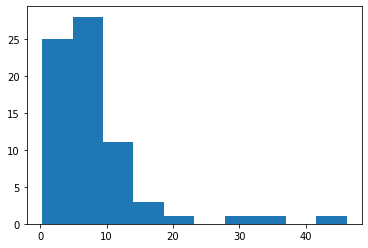

In [50]:
mae_list_final = list(mae_dict_final.values())
print(np.median(mae_list_final))
plt.hist(mae_list_final)

In [63]:
len(mae_df[mae_df.R3 < 10]['R3'].values)

58

**58/71 (82%) of the buildings have a MAPE of 10% or less, and the median MAPE is 6.28%.**

## Export Final MAPE for Each Building

In [104]:
mae_list_final = pd.Series([values for keys, values in mae_dict_final.items()])

In [105]:
# mae_list_final.to_csv(r'MAE_List_R2.csv')

# Merge Building Data with Meter Reading Data

- Merge Building Names with `berkeley_date` using building_id

In [65]:
building_data_updated = building_data_updated.sort_values(by='ashrae_id')
building_names = building_data_updated[['ashrae_id', 'name']]

In [68]:
building_names.rename(columns={'ashrae_id':'building_id'}, inplace=True)

In [69]:
building_names.tail(5)

,building_id,name
54,649,Tan Hall
17,652,University Hall
55,653,Valley Life Sciences Building
56,654,Wellman Hall
65,655,Zellerbach Hall


In [70]:
berkeley_date = berkeley_date.merge(building_names, how='left', on='building_id')

# Merge Actual Meter Reading Data with Prediction Data

- Two final dataframes
    1. meter reading/prediction data is compiled into one list containing all buildings
        - i.e. data for building 565, then data for building 567, then data for building 568, etc.
    2. building names are the columns, so there is a separate column for each building's actual and predicted values

## Create building+date key to be used for merge

In [81]:
building_date_key = []

for index, rows in berkeley_date.iterrows():
    key = str(str(rows['building_id']) + '_' + str(rows['Date']))
    building_date_key.append(key)

In [82]:
berkeley_date

,Date,Year,building_id,meter_reading_scraped,name
0,2016-01-01,2016,565,186.0,Alumni House
1,2016-01-02,2016,565,189.0,Alumni House
2,2016-01-03,2016,565,232.0,Alumni House
3,2016-01-04,2016,565,298.0,Alumni House
4,2016-01-05,2016,565,309.0,Alumni House
...,...,...,...,...,...
105815,2019-11-26,2019,655,3359.0,Zellerbach Hall
105816,2019-11-27,2019,655,3031.0,Zellerbach Hall
105817,2019-11-28,2019,655,2900.0,Zellerbach Hall
105818,2019-11-29,2019,655,3314.0,Zellerbach Hall


In [83]:
berkeley_date.insert(3, column = 'Building_Date_Key', value = building_date_key)

In [84]:
berkeley_date.head(5)

,Date,Year,building_id,Building_Date_Key,meter_reading_scraped,name
0,2016-01-01,2016,565,565_2016-01-01,186.0,Alumni House
1,2016-01-02,2016,565,565_2016-01-02,189.0,Alumni House
2,2016-01-03,2016,565,565_2016-01-03,232.0,Alumni House
3,2016-01-04,2016,565,565_2016-01-04,298.0,Alumni House
4,2016-01-05,2016,565,565_2016-01-05,309.0,Alumni House


## Create Predictions dataframe to merge with Actual Meter Readings dataframe

### Create `sar_pred_df` from first building (#565)

In [75]:
sar_pred_df = pd.DataFrame(sar_pred_dict_final[565], columns = ['meter_reading_predictions'])

In [76]:
key_565 = ['565']*28

In [77]:
sar_pred_df.insert(0, column='building_id', value= key_565)

In [79]:
sar_pred_df.tail(5)

,building_id,meter_reading_predictions
2019-11-24,565,240.675443
2019-11-25,565,311.803594
2019-11-26,565,318.700873
2019-11-27,565,318.360307
2019-11-28,565,240.770934


### Add rest of predictions for each building to `sar_pred_df`

In [85]:
sar_pred_keys = list(sar_pred_dict_final.keys())

In [86]:
len(sar_pred_keys)

71

In [87]:
for i in sar_pred_keys[1:]:
    sar_pred_add, key = None, []
    sar_pred_add = pd.DataFrame(sar_pred_dict_final[i], columns = ['meter_reading_predictions'])
    key = [str(int(i))]*28
    sar_pred_add.insert(0, column='building_id', value = key)
    sar_pred_df = sar_pred_df.append(sar_pred_add)

In [88]:
sar_pred_df = sar_pred_df.reset_index()

### Create building+date key for merge

In [89]:
prediction_date_key = []

for index, rows in sar_pred_df.iterrows():
    key = str(str(rows['building_id']) + '_' + str(rows['index']))
    prediction_date_key.append(key)

In [90]:
sar_pred_df.insert(2, column='Building_Date_Key', value= prediction_date_key)

In [91]:
sar_pred_df

,index,building_id,Building_Date_Key,meter_reading_predictions
0,2019-11-01,565,565_2019-11-01 00:00:00,309.656306
1,2019-11-02,565,565_2019-11-02 00:00:00,243.660896
2,2019-11-03,565,565_2019-11-03 00:00:00,241.133169
3,2019-11-04,565,565_2019-11-04 00:00:00,316.424302
4,2019-11-05,565,565_2019-11-05 00:00:00,318.190946
...,...,...,...,...
1983,2019-11-24,655,655_2019-11-24 00:00:00,3189.840693
1984,2019-11-25,655,655_2019-11-25 00:00:00,3062.888694
1985,2019-11-26,655,655_2019-11-26 00:00:00,3260.437301
1986,2019-11-27,655,655_2019-11-27 00:00:00,3309.349651


In [96]:
prediction_date_key = []

for index, values in sar_pred_df['Building_Date_Key'].iteritems():
    values = values.split(' ')
    prediction_date_key.append(values[0])
    
sar_pred_df['Building_Date_Key'] = prediction_date_key

In [97]:
sar_pred_df.head(5)

,index,building_id,Building_Date_Key,meter_reading_predictions
0,2019-11-01,565,565_2019-11-01,309.656306
1,2019-11-02,565,565_2019-11-02,243.660896
2,2019-11-03,565,565_2019-11-03,241.133169
3,2019-11-04,565,565_2019-11-04,316.424302
4,2019-11-05,565,565_2019-11-05,318.190946


## 1st Final Dataframe: Merge Readings and Predictions Dataframes

In [98]:
berkeley_date = berkeley_date.merge(sar_pred_df, how='left', on='Building_Date_Key')

In [99]:
del berkeley_date['building_id_y']
del berkeley_date['index']

In [100]:
berkeley_date.rename(columns={'building_id_x':'building_id'}, inplace=True)

In [101]:
berkeley_date = berkeley_date[['Date', 'building_id', 'name', 'meter_reading_scraped', 'meter_reading_predictions']]

In [102]:
berkeley_date['meter_reading_predictions'].isna().value_counts()

True     103832
False      1988
Name: meter_reading_predictions, dtype: int64

In [103]:
berkeley_date

,Date,building_id,name,meter_reading_scraped,meter_reading_predictions
0,2016-01-01,565,Alumni House,186.0,NaN
1,2016-01-02,565,Alumni House,189.0,NaN
2,2016-01-03,565,Alumni House,232.0,NaN
3,2016-01-04,565,Alumni House,298.0,NaN
4,2016-01-05,565,Alumni House,309.0,NaN
...,...,...,...,...,...
105815,2019-11-26,655,Zellerbach Hall,3359.0,3260.437301
105816,2019-11-27,655,Zellerbach Hall,3031.0,3309.349651
105817,2019-11-28,655,Zellerbach Hall,2900.0,3351.314087
105818,2019-11-29,655,Zellerbach Hall,3314.0,NaN


In [436]:
berkeley_date = berkeley_date.fillna(0)

## Export 1st Final Dataframe

In [137]:
# berkeley_date.to_csv(r'Load_Data_with_Predictions_R4.csv')

## 2nd Final Dateframe: Building Names as Columns

### Create `export_df` from first building (#565)

In [148]:
## Create CSV:
export_df = pd.DataFrame(data = berkeley_date_dict[565].meter_reading_scraped.values, index = berkeley_date.Date.values[:1430])
export_df.columns = ['Alumni House']
export_df['Alumni House Predicted'] = sar_pred_dict[565]

In [149]:
export_df

,Alumni House,Alumni House Predicted
2016-01-01,186.0,NaN
2016-01-02,189.0,NaN
2016-01-03,232.0,NaN
2016-01-04,298.0,NaN
2016-01-05,309.0,NaN
...,...,...
2019-11-26,378.0,363.142243
2019-11-27,297.0,362.408779
2019-11-28,214.0,355.023309
2019-11-29,215.0,NaN


### Add rest of buildings to `export_df`

In [150]:
broken_ids = [603,604,618]

In [151]:
export_keys = []

for index, rows in building_names.iterrows():
    if rows['building_id'] not in broken_ids:
        export_keys.append((rows['building_id'], rows['name']))

In [152]:
export_keys[0]

(565, 'Alumni House ')

In [153]:
for i in export_keys[1:]:
    export_df[i[1]] = berkeley_date_dict[i[0]].meter_reading_scraped.values
    export_df[i[1] + ' Predicted'] = sar_pred_dict[i[0]]

In [154]:
export_df

,Alumni House,Alumni House Predicted,BAMPFA,BAMPFA Predicted,2200 Bancroft Way,2200 Bancroft Way Predicted,Barker Hall,Barker Hall Predicted,Barrows Hall,Barrows Hall Predicted,Bechtel Engineering Center,Bechtel Engineering Center Predicted,Blum Hall,Blum Hall Predicted,California Hall,California Hall Predicted,Calvin Laboratory,Calvin Laboratory Predicted,Campbell Hall,Campbell Hall Predicted,2000 Carleton,2000 Carleton Predicted,Cesar Chavez Student Center,Cesar Chavez Student Center Predicted,2251 College Avenue,2251 College Avenue Predicted,Cory Hall,Cory Hall Predicted,Davis Hall,Davis Hall Predicted,Doe Annex,Doe Annex Predicted,Doe Memorial Library,Doe Memorial Library Predicted,Donner Laboratory,Donner Laboratory Predicted,Durant Hall,Durant Hall Predicted,Dwinelle Hall,Dwinelle Hall Predicted,Energy Biosciences Building,Energy Biosciences Building Predicted,Etcheverry Hall,Etcheverry Hall Predicted,Evans Hall,Evans Hall Predicted,Gardner Stacks,Gardner Stacks Predicted,Giannini Hall,Giannini Hall Predicted,Giauque Hall,Giauque Hall Predicted,Gilman Hall,Gilman Hall Predicted,Greek Theater,Greek Theater Predicted,Haas Pavilion,Haas Pavilion Predicted,Haviland Hall,Haviland Hall Predicted,Hazardous Material Facility,Hazardous Material Facility Predicted,Hearst Field Annex,Hearst Field Annex Predicted,Hearst Gym,Hearst Gym Predicted,Hearst Memorial Mining,Hearst Memorial Mining Predicted,Hertz Hall,Hertz Hall Predicted,Hildebrand Hall,Hildebrand Hall Predicted,Hilgard Hall,Hilgard Hall Predicted,International House,International House Predicted,Koshland Hall,Koshland Hall Predicted,Kroeber Hall,Kroeber Hall Predicted,Latimer Hall,Latimer Hall Predicted,Lewis Hall,Lewis Hall Predicted,Li Ka-Shing Center,Li Ka-Shing Center Predicted,Maxwell Garage,Maxwell Garage Predicted,McCone Hall,McCone Hall Predicted,McLaughlin Hall,McLaughlin Hall Predicted,Minor Hall,Minor Hall Predicted,Moffitt Library,Moffitt Library Predicted,Morgan Hall,Morgan Hall Predicted,Morrison Hall,Morrison Hall Predicted,Mulford Hall,Mulford Hall Predicted,North Gate Hall,North Gate Hall Predicted,O'Brien Hall,O'Brien Hall Predicted,Northwest Parking Garage,Northwest Parking Garage Predicted,2222 Piedmont Ave,2222 Piedmont Ave Predicted,2224 Piedmont Ave,2224 Piedmont Ave Predicted,2232 Piedmont Ave,2232 Piedmont Ave Predicted,2234 Piedmont Ave,2234 Piedmont Ave Predicted,2240 Piedmont Ave,2240 Piedmont Ave Predicted,Simpson Center,Simpson Center Predicted,Soda Hall,Soda Hall Predicted,South Hall,South Hall Predicted,Sproul Hall,Sproul Hall Predicted,California Memorial Stadium,California Memorial Stadium Predicted,Stanley Hall,Stanley Hall Predicted,Stephens Hall,Stephens Hall Predicted,Tan Hall,Tan Hall Predicted,University Hall,University Hall Predicted,Valley Life Sciences Building,Valley Life Sciences Building Predicted,Wellman Hall,Wellman Hall Predicted,Zellerbach Hall,Zellerbach Hall Predicted
2016-01-01,186.0,NaN,3499.134401,NaN,105.642991,NaN,6031.0,NaN,3514.752,NaN,425.0,NaN,222.920000,NaN,505.0,NaN,584.0,NaN,3007.00,NaN,1047.4,NaN,1772.0,NaN,123.16,NaN,10758.618140,NaN,2796.63,NaN,3989.0,NaN,1180.0,NaN,1812.0,NaN,354.000000,NaN,1963.000000,NaN,8968.320,NaN,8471.0,NaN,3572.99890,NaN,1766.0,NaN,1086.000000,NaN,1819.0,NaN,1419.0,NaN,226.0,NaN,12787.40000,NaN,297.0,NaN,1354.22,NaN,499.187016,NaN,1226.75,NaN,12207.0,NaN,688.0,NaN,10254.00000,NaN,1811.0,NaN,3065.0,NaN,17263.48549,NaN,754.1,NaN,12086.99670,NaN,4045.14,NaN,25972.979,NaN,395.786716,NaN,4777.0,NaN,384.0,NaN,1617.98,NaN,1953.0,NaN,2380.0,NaN,436.0,NaN,880.0,NaN,216.55,NaN,1185.000000,NaN,658.684,NaN,3.36,NaN,84.98,NaN,2.89,NaN,2.72,NaN,42.27,NaN,3773.0,NaN,8821.83100,NaN,201.0,NaN,1549.0,NaN,4473.00000,NaN,34860.4085,NaN,689.0,NaN,8811.92454,NaN,1720.63750,NaN,13934.99653,NaN,1233.0,NaN,1572.0,NaN
2016-01-02,189.0,NaN,3499.134401,NaN,105.642991,NaN,6118.0,NaN,4318.272,NaN,435.0,NaN,223.409999,NaN,493.0,NaN,566.0,NaN,2800.50,NaN,1000.2,NaN,1337.0,NaN,123.68,NaN,10695.781860,NaN,2351.00,N

## Export 2nd Final Dataframe

In [155]:
# export_df.to_csv(r'Load_Data_with_Predictions.csv')